In [1]:
import time
start0 = time.time()

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, scale
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve, classification_report
from sklearn.model_selection import learning_curve, StratifiedShuffleSplit, GridSearchCV, train_test_split
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.utils import resample
from imblearn.under_sampling import NearMiss
from collections import Counter

upsample_flag = 2   #1: Minor class upsampled; 2: Major class downsampled; 3: Baseline dataset; 
                    
function_flag = True

%matplotlib inline
print('Dataset Value: {}' .format(upsample_flag))

Dataset Value: 2


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Data Preprocessing 

Data for this project was obtained from IBM.

In [2]:
#https://www.ibm.com/communities/analytics/watson-analytics-blog/guide-to-sample-datasets/
url = 'http://bit.ly/gta-mlnd-capstone'
df = pd.read_csv(url)

In [3]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
df.shape

(7043, 21)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null object
dtypes: float64(1), int64(2), obj

In [6]:
#By setting errors to 'coerce' a 'NaN will be inserted when there is an error.
#https://pandas.pydata.org/pandas-docs/stable/generated/pandas.to_numeric.html

df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors = 'coerce')

In [7]:
df['MonthlyCharges'].isnull().sum()

0

In [8]:
df['TotalCharges'].isnull().sum()

11

In [9]:
df[df['TotalCharges'].isnull()]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No


In [10]:
index_row = []
for index, row in df.iterrows():
    try:
        if pd.isnull(row['TotalCharges']):
            df.set_value(index, 'TotalCharges', row['MonthlyCharges'])
            print(index)
    except:
        index_row.append(row)

488
753
936
1082
1340
3331
3826
4380
5218
6670
6754


In [11]:
len(index_row)

0

In [12]:
df[df['tenure'] == 1].head(3)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
20,8779-QRDMV,Male,1,No,No,1,No,No phone service,DSL,No,...,Yes,No,No,Yes,Month-to-month,Yes,Electronic check,39.65,39.65,Yes
22,1066-JKSGK,Male,0,No,No,1,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20.15,20.15,Yes


In [13]:
df['ratio'] = df['TotalCharges'] / df['MonthlyCharges']

In [14]:
df_tenure_1 = df[df['tenure'] == 1]
df_tenure_1.head(10)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,ratio
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,1.0
20,8779-QRDMV,Male,1,No,No,1,No,No phone service,DSL,No,...,No,No,Yes,Month-to-month,Yes,Electronic check,39.65,39.65,Yes,1.0
22,1066-JKSGK,Male,0,No,No,1,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20.15,20.15,Yes,1.0
27,8665-UTDHZ,Male,0,Yes,Yes,1,No,No phone service,DSL,No,...,No,No,No,Month-to-month,No,Electronic check,30.20,30.20,Yes,1.0
33,7310-EGVHZ,Male,0,No,No,1,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,Month-to-month,No,Bank transfer (automatic),20.20,20.20,No,1.0
34,3413-BMNZE,Male,1,No,No,1,Yes,No,DSL,No,...,No,No,No,Month-to-month,No,Bank transfer (automatic),45.25,45.25,No,1.0
70,2273-QCKXA,Male,0,No,No,1,Yes,No,DSL,No,...,Yes,No,No,Month-to-month,No,Mailed check,49.05,49.05,No,1.0
80,5919-TMRGD,Female,0,No,Yes,1,Yes,No,Fiber optic,No,...,No,Yes,No,Month-to-month,Yes,Electronic check,79.35,79.35,Yes,1.0
91,2424-WVHPL,Male,1,No,No,1,Yes,No,Fiber optic,No,...,Yes,No,No,Month-to-month,No,Electronic check,74.70,74.70,No,1.0
100,6380-ARCEH,Male,0,No,No,1,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20.20,20.20,No,1.0


In [15]:
df[df['tenure'] == 2].head(3)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,ratio
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,2.008357
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,2.144979
31,4929-XIHVW,Male,1,Yes,No,2,Yes,No,Fiber optic,No,...,No,Yes,Yes,Month-to-month,Yes,Credit card (automatic),95.50,181.65,No,1.902094


In [16]:
df.iloc[4]['MonthlyCharges'] * df.iloc[4]['tenure'] 

141.4

In [17]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,ratio
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2279.798992,32.374993
std,0.368612,24.559481,30.090047,2266.730170,24.593918
min,0.000000,0.000000,18.250000,18.800000,1.000000
25%,0.000000,9.000000,35.500000,398.550000,8.717230
50%,0.000000,29.000000,70.350000,1394.550000,28.673115
75%,0.000000,55.000000,89.850000,3786.600000,55.244460
max,1.000000,72.000000,118.750000,8684.800000,79.341772


In [18]:
print('The total number of customers who did not churn: {}' .format(df['Churn'].value_counts()[0]))
print('The total number of customers who did churn: {}' .format(df['Churn'].value_counts()[1]))

The total number of customers who did not churn: 5174
The total number of customers who did churn: 1869


In [19]:
df.columns.tolist()

['customerID',
 'gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'tenure',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'MonthlyCharges',
 'TotalCharges',
 'Churn',
 'ratio']

In [20]:
features = df[[
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod']]

In [21]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 14 columns):
Partner             7043 non-null object
Dependents          7043 non-null object
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
dtypes: object(14)
memory usage: 770.4+ KB


In [22]:
columns_list = df.columns.tolist()

In [23]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,ratio
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,1.000000
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,No,No,No,One year,No,Mailed check,56.95,1889.50,No,33.178227
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,2.008357
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,43.516548
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,2.144979


In [24]:
df['Churn'] = df['Churn'].map({'No': 0, 'Yes': 1})

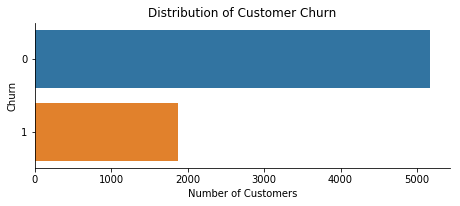

In [25]:
sns.catplot(y="Churn", kind="count", data=df, height=2.6, aspect=2.5, orient='h')
plt.xlabel('Number of Customers')
plt.title('Distribution of Customer Churn', fontsize=12)
plt.show()

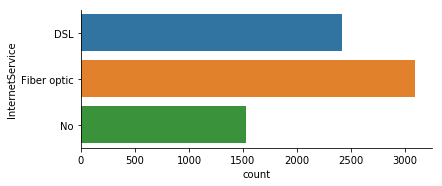

In [26]:
sns.catplot(y='InternetService', kind='count', data=df, height=2.5, aspect=2.5, orient='h')
plt.show()

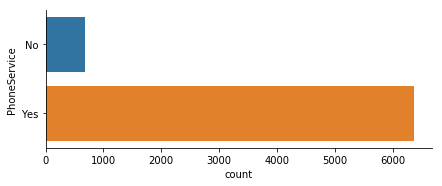

In [27]:
sns.catplot(y='PhoneService', kind='count', data=df, height=2.5, aspect=2.5, orient='h')
plt.show()

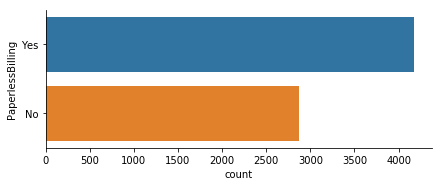

In [28]:
sns.catplot(y='PaperlessBilling', kind='count', data=df, height=2.5, aspect=2.5, orient='h')
plt.show()

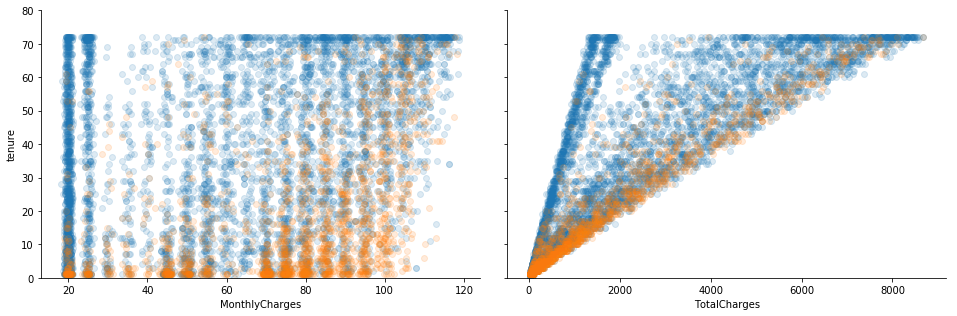

In [29]:
g = sns.PairGrid(df, y_vars=["tenure"], 
                 x_vars=["MonthlyCharges","TotalCharges"], 
                 height=4.5, 
                 hue="Churn", 
                 aspect=1.5)
g.map(plt.scatter, alpha=0.15)
plt.ylim(0, 80)
plt.show()

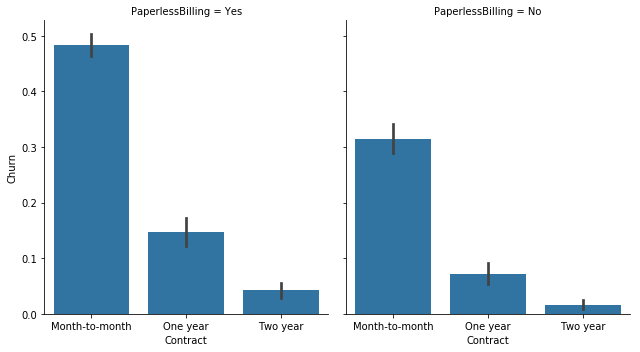

In [30]:
g = sns.FacetGrid(df, col="PaperlessBilling", height=5, aspect=.9)
g.map(sns.barplot, "Contract", "Churn", order = ['Month-to-month', 'One year', 'Two year'])
plt.show()

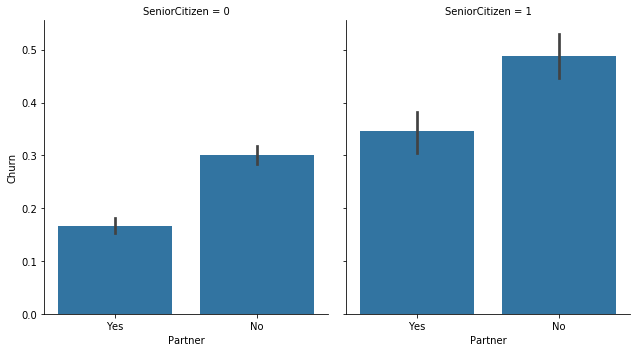

In [31]:
g = sns.FacetGrid(df, col="SeniorCitizen", height=5, aspect=.9)
g.map(sns.barplot, "Partner", "Churn", order= ['Yes', 'No'])
plt.show()

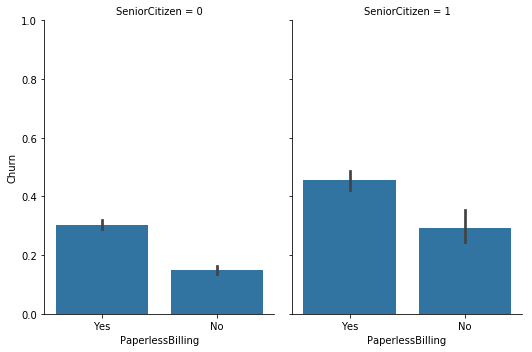

In [66]:
g = sns.FacetGrid(df, col="SeniorCitizen", height=5, aspect=0.75)
g.map(sns.barplot, "PaperlessBilling", "Churn", order= ['Yes', 'No'])
plt.ylim(0, 1.0)
plt.show()

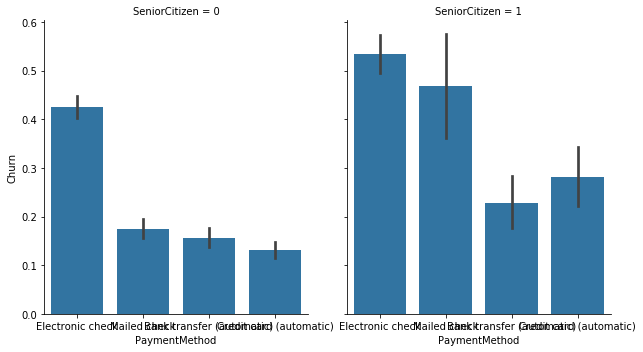

In [32]:
g = sns.FacetGrid(df, col='SeniorCitizen', height=5, aspect=.9)
g.map(sns.barplot, 'PaymentMethod', 'Churn', order = ['Electronic check', 
                                                     'Mailed check',
                                                     'Bank transfer (automatic)',
                                                     'Credit card (automatic)'])
plt.show()

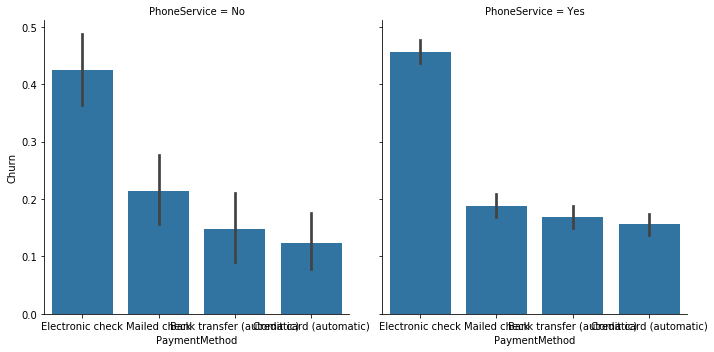

In [33]:
g = sns.FacetGrid(df, col='PhoneService', height=5, aspect=1.0)
g.map(sns.barplot, 'PaymentMethod', 'Churn', order = ['Electronic check', 
                                                     'Mailed check',
                                                     'Bank transfer (automatic)',
                                                     'Credit card (automatic)'])
plt.show()

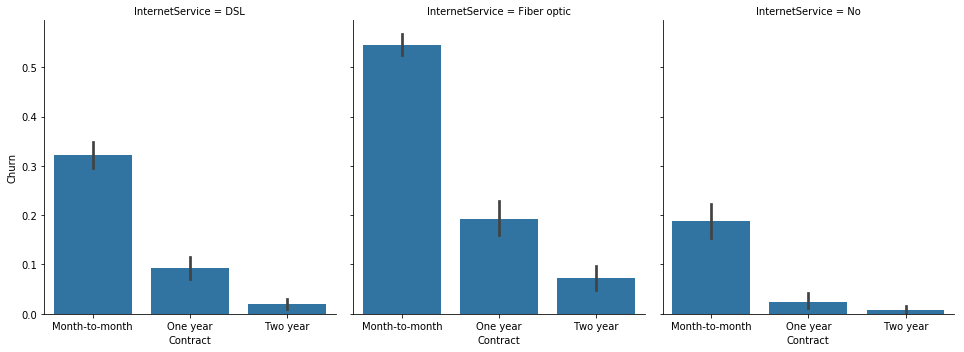

In [34]:
g = sns.FacetGrid(df, col='InternetService', height=5, aspect=.9)
g.map(sns.barplot, 'Contract', 'Churn', order = ['Month-to-month', 'One year', 'Two year'])
plt.show()

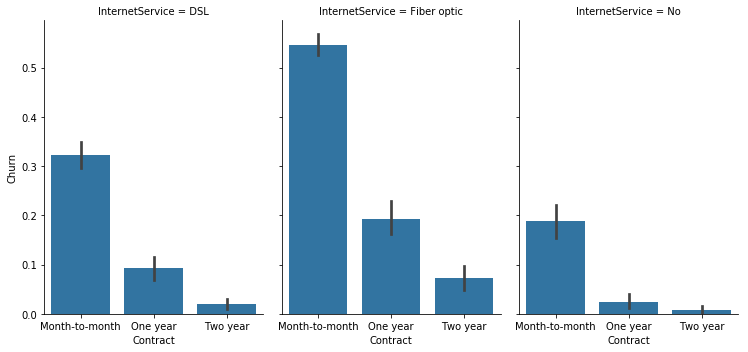

In [69]:
g = sns.FacetGrid(df, col='InternetService', height=5, aspect=.70)
g.map(sns.barplot, 'Contract', 'Churn', order = ['Month-to-month', 'One year', 'Two year'])
plt.show()

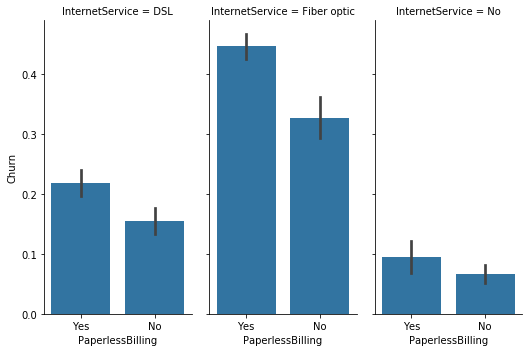

In [36]:
g = sns.FacetGrid(df, col='InternetService', height=5, aspect=.50)
g.map(sns.barplot, 'PaperlessBilling', 'Churn', order = ['Yes', 'No'])
plt.show()

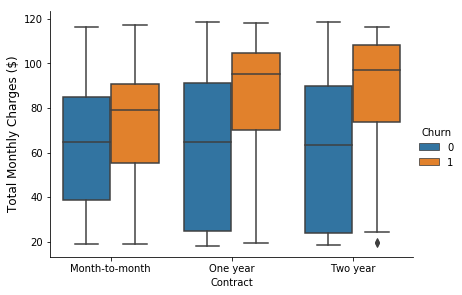

In [37]:
sns.catplot(x="Contract", y="MonthlyCharges", hue="Churn", kind="box", data=df, height=4.2, aspect=1.4)
plt.ylabel('Total Monthly Charges ($)', fontsize=12)
plt.show()

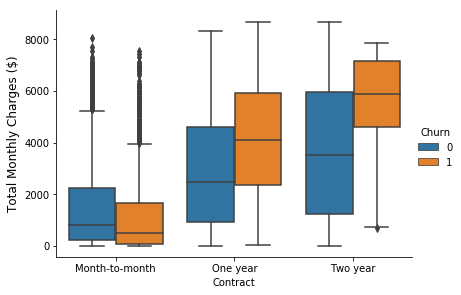

In [38]:
sns.catplot(x="Contract", y="TotalCharges", hue="Churn", kind="box", data=df, height=4.2, aspect=1.4)
plt.ylabel('Total Monthly Charges ($)', fontsize=12)
plt.show()

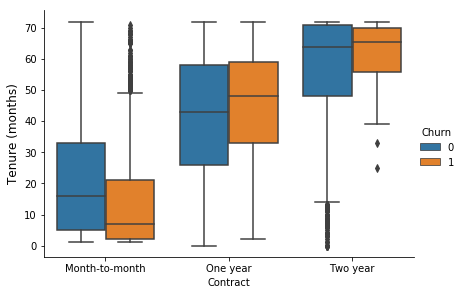

In [39]:
sns.catplot(x="Contract", y="tenure", hue="Churn", kind="box", data=df, height=4.2, aspect=1.4)
plt.ylabel('Tenure (months)', fontsize=12)
plt.show()

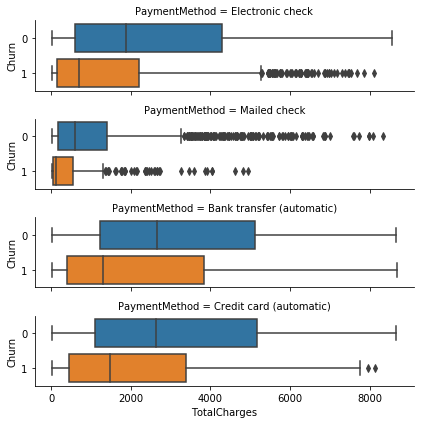

In [40]:
sns.catplot(y="Churn", 
            x="TotalCharges", 
            row="PaymentMethod", 
            kind="box", data=df, height=1.5, aspect=4, orient='h')
plt.show()

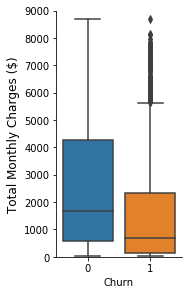

In [49]:
sns.catplot(x="Churn", y="TotalCharges", kind="box", data=df, height=4.2, aspect=0.65)
plt.ylabel('Total Monthly Charges ($)', fontsize=12)
plt.ylim(0, 9000)
plt.show()

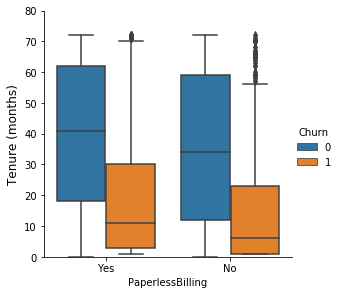

In [60]:
sns.catplot(x="PaperlessBilling", y="tenure", hue="Churn", kind="box", data=df, height=4.2, aspect=1.0)
plt.ylabel('Tenure (months)', fontsize=12)
plt.ylim(0, 80)
plt.show()

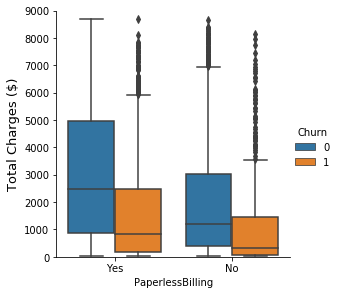

In [59]:
sns.catplot(x="PaperlessBilling", y="TotalCharges", hue="Churn", kind="box", data=df, height=4.2, aspect=1.0)
plt.ylabel('Total Charges ($)', fontsize=13)
plt.ylim(0, 9000)
plt.show()

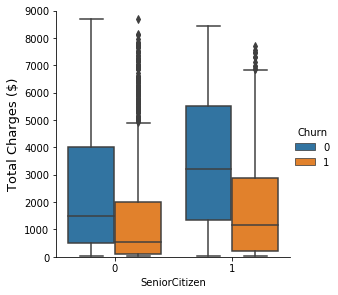

In [61]:
sns.catplot(x="SeniorCitizen", y="TotalCharges", hue="Churn", kind="box", data=df, height=4.2, aspect=1.0)
plt.ylabel('Total Charges ($)', fontsize=13)
plt.ylim(0, 9000)
plt.show()

In [84]:
df_slice = df[(df['TotalCharges'] < 2500) & (df['TotalCharges'] > 1500) & (df['tenure'] > 25)]
df_slice.shape

(558, 22)

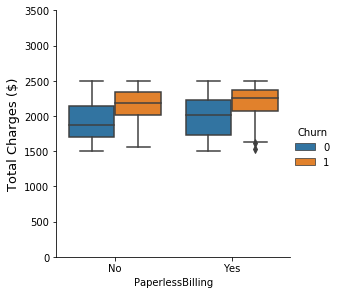

In [83]:
sns.catplot(x="PaperlessBilling", y="TotalCharges", hue="Churn", kind="box", data=df_slice, height=4.2, aspect=1.0)
plt.ylabel('Total Charges ($)', fontsize=13)
plt.ylim(0, 3500)
plt.show()